# Data exploration

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycld2 as cld2
from langdetect import detect as langdetect
from tqdm.notebook import trange, tqdm
sns.set_theme()

## Loading the scrapped datasets

In [15]:
DATA_DIR = "data/"

In [16]:
df = pd.read_json(DATA_DIR + "all_lyrics.json")
df['lyrics_state'] = df['lyrics_state'].apply(lambda state: 0 if state == "missing" else 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18176 entries, 0 to 18175
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          18176 non-null  int64 
 1   artist        18176 non-null  object
 2   title         18176 non-null  object
 3   lyrics        17052 non-null  object
 4   lyrics_state  18176 non-null  int64 
 5   country       18176 non-null  object
dtypes: int64(2), object(4)
memory usage: 994.0+ KB


In [17]:
df.head()

,year,artist,title,lyrics,lyrics_state,country
0,2005,tony christie ft peter kay,(is this the way to) amarillo,July 2020 Singles Release Calendar Lyrics7/1\n...,1,uk
1,2005,shayne ward,that's my goal,"That’s My Goal Lyrics\nYeah, you know where I'...",1,uk
2,2005,crazy frog,axel f,Axel F Lyrics\nRing ding ding daa baa\nBaa ara...,1,uk
3,2005,james blunt,you're beautiful,You’re Beautiful Lyrics\nMy life is brilliant\...,1,uk
4,2005,pussycat dolls ft busta rhymes,don't cha,"Don’t Cha Lyrics\nOkay (Ahh)\nYeah (Ahh)\nOh, ...",1,uk


## Singles per year

Text(0, 0.5, 'Number of artists')

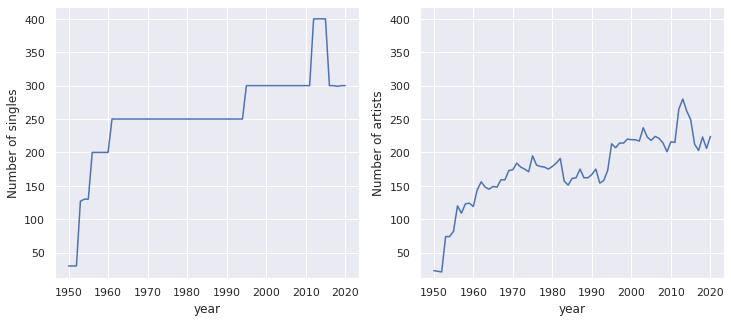

In [18]:
yearly_df = df.groupby('year')
plt.figure(figsize=(12, 5))

# Plots the number of titles per year
ax = plt.subplot(121)
yearly_titles = yearly_df.count()['title']
yearly_titles.plot(ax=ax)
ylim = ax.get_ylim()
plt.ylabel('Number of singles')

# Plots the number of unique artists per year
ax = plt.subplot(122)
yearly_df.artist.nunique().plot(ax=ax)
# Sets the same ylim as for the first plot
ax.set_ylim(ylim)

plt.ylabel('Number of artists')

## Missing data

In [19]:
def yearly_missing_info(df, country=None):
    """
    Returns a dataframe containing the number of titles, number of titles
    with complete lyrics, number of missing lyrics and the proportions of
    titles whose lyrics are missing.
    """
    # Filter by country if required
    if country is not None:
        df = df[df['country'] == country]
    
    yearly_df = df.groupby('year')
    # Yearly count of titles
    yearly_titles = yearly_df.count()['title']

    # Yearly count of songs with complete lyrics
    yearly_complete_lyrics = yearly_df.sum()['lyrics_state']
    # Yearly proportions of songs whose lyrics are not missing
    yearly_missing_proportion = 1 - (yearly_complete_lyrics / yearly_titles)

    yearly_df = pd.DataFrame({'titles_count': yearly_titles, 'complete': yearly_complete_lyrics, 'missing': yearly_titles - yearly_complete_lyrics,
                              'missing_proportion': yearly_missing_proportion})
    return yearly_df

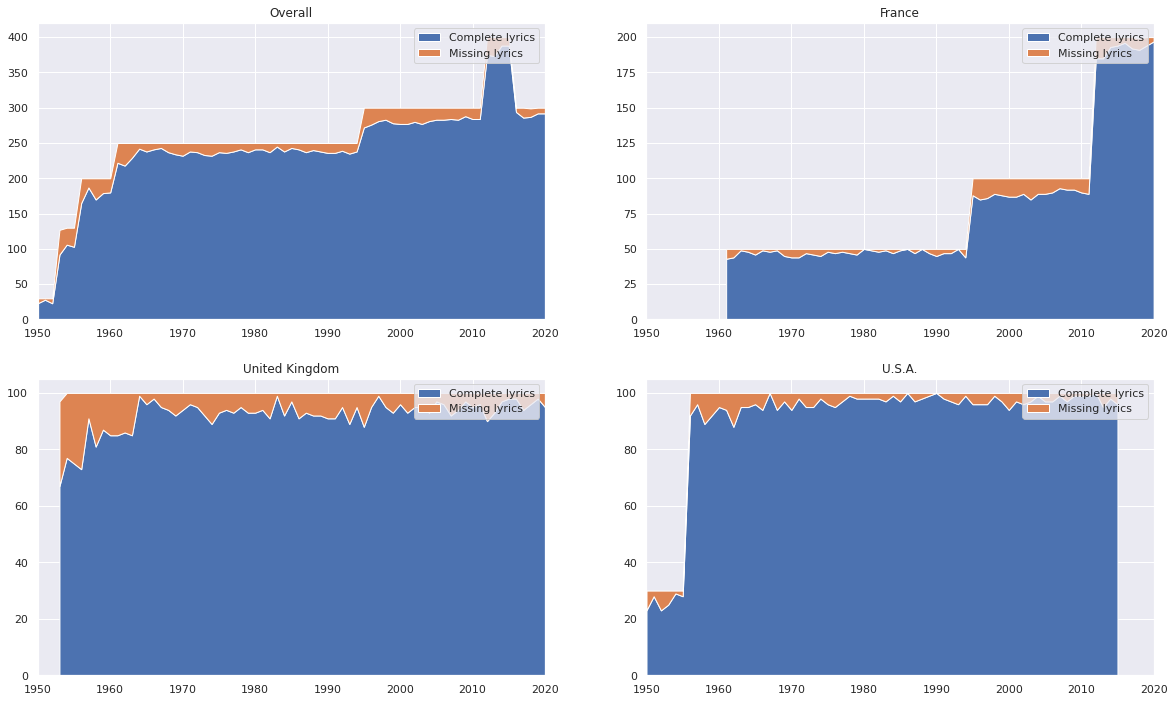

In [20]:
plt.figure(figsize=(20, 12))

def plot_missing_lyrics(ax, title, country=None):
    yearly_df = yearly_missing_info(df, country=country)
    plt.stackplot(yearly_df.index,
                  yearly_df['complete'], yearly_df['missing'],
                  baseline ='zero')
    plt.legend(['Complete lyrics', 'Missing lyrics'])
    plt.xlim(1950, 2020)
    ax.set_title(title)
    
# Plots the proportions of missing lyrics overall and separately for every country
ax = plt.subplot(221)
plot_missing_lyrics(ax, "Overall")
ax = plt.subplot(222)
plot_missing_lyrics(ax, "France", country="fr")
ax = plt.subplot(223)
plot_missing_lyrics(ax, "United Kingdom", country="uk")
ax = plt.subplot(224)
plot_missing_lyrics(ax, "U.S.A.", country="us")

plt.show()

## First cleaning
We first need to apply some basic cleaning on the lyrics. Let's print some of the lyrics:

In [21]:
# We discard the songs whose lyrics are missing
lyrics_df = df[df['lyrics_state'] == 1].drop('lyrics_state', axis=1)

In [22]:
lyrics_df.head()

,year,artist,title,lyrics,country
0,2005,tony christie ft peter kay,(is this the way to) amarillo,July 2020 Singles Release Calendar Lyrics7/1\n...,uk
1,2005,shayne ward,that's my goal,"That’s My Goal Lyrics\nYeah, you know where I'...",uk
2,2005,crazy frog,axel f,Axel F Lyrics\nRing ding ding daa baa\nBaa ara...,uk
3,2005,james blunt,you're beautiful,You’re Beautiful Lyrics\nMy life is brilliant\...,uk
4,2005,pussycat dolls ft busta rhymes,don't cha,"Don’t Cha Lyrics\nOkay (Ahh)\nYeah (Ahh)\nOh, ...",uk


We can first notice that all songs start with a line "SONG NAME Lyrics", which we should remove:

In [24]:
def remove_Lyrics_line(lyrics):
    """
    Removes the beginning of a song lyrics until the "Lyrics" word is found.
    """
    pos = lyrics.find('Lyrics')
    if pos != -1:
        return lyrics[pos + 6:]

In [25]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(remove_Lyrics_line)

## Non-songs items
Some items are not songs lyrics but list of songs, for some reason. This is admitted by the python GENIUS api and cannot be avoided as long as we use their api.

In [28]:
lyrics_lengths = lyrics_df['lyrics'].apply(lambda text: len(text.split(' ')))

Text(0.5, 0, "Number of words in the 'lyrics'")

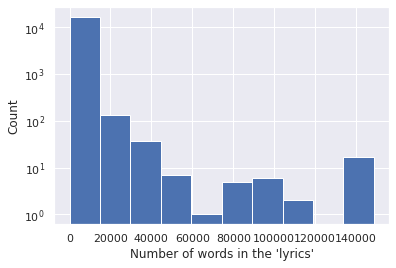

In [29]:
lyrics_lengths.hist(log=True)
plt.ylabel("Count")
plt.xlabel("Number of words in the 'lyrics'")

Over a hundred "songs" are longer than 20000 words, which is of course unrealistic. Actually it even contains memoires, such as "Angela's Ashes" by Frank McCourt.  
To remove those, we'll filter the songs whose lyrics are longer than an arbitrary limit, let's say 1500 words.

In [30]:
lyrics_df = lyrics_df[lyrics_lengths < 1500]

# Language classification
We'll now need to detect the language of every song in order to run the LDA. To do so we don't need to divide the data
by country.  
We'll use the python module ```langdetect```.

## Detection

In [32]:
languages = []
# For every song, detect its language
for row, lyrics in zip(trange(lyrics_df.shape[0]), lyrics_df['lyrics']):
    languages.append(langdetect(lyrics))
lyrics_df['lang'] = languages

  0%|          | 0/16360 [00:00<?, ?it/s]

## Analysis
Let's first have a look at the songs which were detected as neither in french or english:

In [33]:
lyrics_df[~lyrics_df['lang'].isin(['fr', 'en'])]

,year,artist,title,lyrics,country,lang
2,2005,crazy frog,axel f,\nRing ding ding daa baa\nBaa aramba baa bom b...,uk,id
93,2005,daddy yankee,gasolina,\n\nWho's this?\nDa-ddy Yan-kee!\n\nZúmbale ma...,uk,es
514,2010,lady gaga ft beyonce,telephone,"\nSelam, selam, bebeğim, sen mi aradın? Hiçbir...",uk,tr
537,2010,sidney samson ft wizard sleeve,riverside (let's go),Riverside motherfucker\nRiverside motherfucker...,uk,da
546,2010,justin bieber ft ludacris,baby,"\n\nOh, woah\nOh, woah\nOh, woah\n\nVocê sabe ...",uk,pt
...,...,...,...,...,...,...
18019,1990,latino party,the party,Give yourself a little love\nUh! baby and give...,fr,es
18032,1991,crystal waters,gypsy woman (la da dee la da da),\nShe wakes up early every morning\nJust to do...,fr,nl
18051,1991,rem,shiny happy people,\nShiny happy people laughing\n\nMeet me in th...,fr,af
18106,1992,marco masini,perché lo fai,Con questa pioggia nei capelli perché lo fai\n...,fr,it


For now we'll discard those songs as they represent a tiny portion of the total dataset. Nonetheless this list contains errors (for example, Justin Bieber's "Baby" is counted as portuguese, becaused GENIUS.com returned a translation of the original lyrics for some reason).

In [34]:
lyrics_df.loc[~lyrics_df['lang'].isin(['fr', 'en']), 'lang'] = 'other'

Let's have a look at the languages distributions:

In [35]:
def yearly_lang_info(df, country=None):
    """
    Returns a dataframe containing the number of songs in each language
    found per year.
    """
    # Filter by country if required
    if country is not None:
        df = df[df['country'] == country]
    
    yearly_df = df.groupby(['year', 'lang'])
    lang_songs = yearly_df.count().rename({'title': 'title count'}, axis=1)

    return lang_songs['title count'].reset_index()

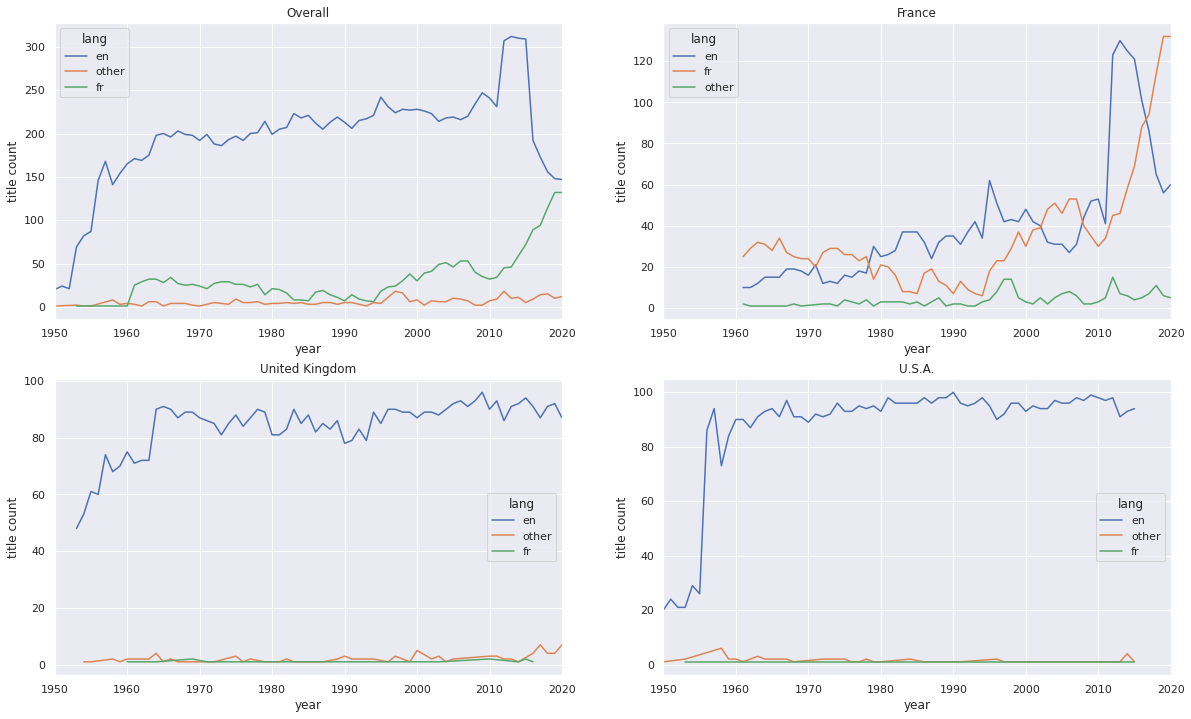

In [36]:
plt.figure(figsize=(20, 12))

def plot_lang_counts(ax, title, country=None):
    yearly_df = yearly_lang_info(lyrics_df, country=country)
    sns.lineplot(data=yearly_df, x="year", y="title count", hue="lang")
    plt.xlim(1950, 2020)
    ax.set_title(title)
    
# Plots the proportions of missing lyrics overall and separately for every country
ax = plt.subplot(221)
plot_lang_counts(ax, "Overall")
ax = plt.subplot(222)
plot_lang_counts(ax, "France", country="fr")
ax = plt.subplot(223)
plot_lang_counts(ax, "United Kingdom", country="uk")
ax = plt.subplot(224)
plot_lang_counts(ax, "U.S.A.", country="us")

plt.show()

## Saving results

In [35]:
lyrics_df.to_csv('data/lang_lyrics_df.tsv', sep="\t")

# Topic modeling

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycld2 as cld2
import gensim
import spacy
from langdetect import detect as langdetect
from tqdm.notebook import trange, tqdm
from csv import DictReader, DictWriter
sns.set_theme()

In [3]:
df = pd.read_csv('data/lang_lyrics_df.tsv', sep="\t")
# Discards the songs whose languages isn't english or french
df = df[df['lang'] != 'other']
# Discards the songs in french that are in the UK or US list
df = df[(df['lang'] == 'en') | (df['country'].isin(['uk', 'us']))]

# Drop the 2 rows that are full of NAs for .. idk why
df = df.dropna()
df.sample(5)

,Unnamed: 0,year,artist,title,lyrics,country,lang
4894,5757,1994.0,take that,sure,"\nSure, so sure\nSure, so sure\nFeel it moving...",uk,en
131,142,2006.0,red hot chili peppers,dani california,\n\nGettin' born in the state of Mississippi\n...,uk,en
2380,2850,1965.0,burt bacharach,trains and boats and planes,Trains and boats and planes are passing by\nTh...,uk,en
150,162,2006.0,madonna,hung up,\nTime goes by so slowly\nTime goes by so slow...,uk,en
11787,13108,1995.0,boyz ii men,i'll make love to you,"\nClose your eyes, make a wish\nAnd blow out t...",fr,en


## Text preprocessing using spaCy

The preprocessing involves the following steps:
* Tokenization
* Stopwords and punctuation removal
* Lemmatization  

Songs are neither in French or English will be ignored as we do not have enough of them to perform a meaningful analsysi, and we otherwise wouldn't be able to interpret the topics. For the former reason, we'll also skip songs that are in French but are not part of the France charts lists.

In [4]:
# We won't need the named entity recognition
excluded_components = ['ner']
nlp_en = spacy.load('en_core_web_sm', exclude=excluded_components)
nlp_fr = spacy.load('fr_core_news_sm', exclude=excluded_components)

We won't load all of the lyrics and process them at once as it would too memory-consuming for some devices (more than 20 GiB required).  
Instead, we'll stream process them using a csv ```DictReader```, and save the resulting strings using ```DictWriter```:

In [24]:
with open('data/lang_lyrics_df.tsv', newline='') as lyrics_file:
    with open('data/processed_df.tsv', 'w', newline='') as save_file:
        reader = DictReader(lyrics_file, delimiter='\t')
        writer = DictWriter(save_file, delimiter='\t',
                            fieldnames=['year', 'artist', 'title', 'country', 'lang', 'doc'])
        writer.writeheader()
        for cnt, row in enumerate(reader):
            # Choose the right pipeline depending on the language
            if row['lang'] == 'en':
                # Apply the SpaCy NLP pipeline
                doc = nlp_en(row['lyrics'])
            # We do not take into account languages other than English or French, and we don't
            # either take into account songs in French that are part of the UK or US lists
            # as we don't have enough of them
            elif row['lang'] == 'fr' and row['country'] == 'fr':
                doc = nlp_fr(row['lyrics'])
            else:
                continue
            # Filters the token that are stopwords, punctuation or (multiple) line breaks
            doc = [token.lemma_.lower() for token in doc if not (token.is_stop or token.is_punct) and token.text[0] != '\n']
            # Saves the resulting document alongside the song's information
            # The doc is saved as a string of the tokens separated by white spaces
            writer.writerow({'year': row['year'], 'artist':row['artist'], 'title': row['title'],
                             'country': row['country'], 'lang': row['lang'],
                             'doc': ' '.join(doc)})
            if cnt % 500 == 0 and cnt > 0:
                print(f"Processed {cnt} songs")

Processed 200 songs
Processed 400 songs
Processed 600 songs
Processed 800 songs
Processed 1000 songs
Processed 1400 songs
Processed 1600 songs
Processed 1800 songs
Processed 2000 songs
Processed 2200 songs
Processed 2400 songs
Processed 2600 songs
Processed 2800 songs
Processed 3000 songs
Processed 3200 songs
Processed 3600 songs
Processed 3800 songs
Processed 4000 songs
Processed 4200 songs
Processed 4400 songs
Processed 4600 songs
Processed 4800 songs
Processed 5000 songs
Processed 5200 songs
Processed 5400 songs
Processed 5600 songs
Processed 5800 songs
Processed 6000 songs
Processed 6200 songs
Processed 6400 songs
Processed 6600 songs
Processed 6800 songs
Processed 7000 songs
Processed 7200 songs
Processed 7400 songs
Processed 7600 songs
Processed 7800 songs
Processed 8000 songs
Processed 8200 songs
Processed 8400 songs
Processed 8600 songs
Processed 8800 songs
Processed 9000 songs
Processed 9200 songs
Processed 9400 songs
Processed 9600 songs
Processed 9800 songs
Processed 10000 s